# Variational Autoencoder

## Data preparation

In [1]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

torch.manual_seed(123)

batch_size = 512
learning_rate = 5*1e-3
num_epochs = 50
latent_dim = 2 # <---------------------
hidden_dim = [512, 256]
label_dim = 10

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1)),
])

train_data = datasets.FashionMNIST('FashionMNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('FashionMNIST_data/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, _ in train_loader:
    input_dim = X.shape[1]
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    break

# Sempre choro nessa linha
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Shape of X [N, C, H, W]: torch.Size([512, 784])
Using device: cpu


## Autoencoder definition

In [2]:
@dataclass
class AEOutput:
    """
    Dataclass for AE output.
    """
    z_proj: torch.Tensor    
    x_recon: torch.Tensor    
    loss: torch.Tensor

class AE(nn.Module):
    """
    Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim, label_dim=0):
        super(AE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim + label_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim + label_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim + label_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim + label_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x, y=None):
        return self.encoder(x if y is None else torch.cat((x, y), dim=1))
        
    def decode(self, z, y=None):
        return self.decoder(z if y is None else torch.cat((z, y), dim=1))
    
    def forward(self, x, y=None, compute_loss: bool = True):
        z_proj = self.encode(x, y)
        recon_x = self.decode(z_proj, y)
        loss = None
        
        if compute_loss:
          loss = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        
        return AEOutput(
                z_proj=z_proj,
                x_recon=recon_x,
                loss=loss,
            )

## Variational Autoencoder definition

In [3]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim, label_dim=0):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim + label_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim + label_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], 2 * latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)
        self.softplus = nn.Softplus()

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim + label_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
            decoder_layers_list.append(nn.Sigmoid())
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim + label_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))
            decoder_layers_list.append(nn.Sigmoid())

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x, eps: float = 1e-8, y = None):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
    
        x = self.encoder(x if y is None else torch.cat((x, y), dim=1))
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z, y=None):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z if y is None else torch.cat((z, y), dim=1))
    
    def forward(self, x, y=None, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        
        dist = self.encode(x, y=y)
        z = self.reparameterize(dist)
        recon_x = self.decode(z, y=y)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

## Train and Test functions

In [4]:
def train(model, dataloader, optimizer, prev_updates, is_conditioned = False):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
        is_conditioned: Sets the usage of training labels on encoder's input and decoder's input
    """
    model.train()  # Set the model to training mode
    
    loss_history = []
    for batch_idx, (data, labels) in enumerate(tqdm(dataloader, desc='Training')):
        n_upd = prev_updates + batch_idx
        data = data.to(device)
        y = None
        
        if is_conditioned:
            y = torch.nn.functional.one_hot(labels)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data, y=y)  # Forward pass
        
        loss = output.loss
        loss.backward()

        optimizer.step()  # Update the model parameters
        
        loss_history.append(loss.item())

    print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Train set loss: {np.mean(loss_history):.4f}') 

    return prev_updates + len(dataloader), loss_history

def test(model, dataloader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            
    test_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f}')

    return test_loss

## Train the Autoencoder

In [5]:
print("Training Autoencoder...")

model_AE = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_AE)
optimizer = torch.optim.AdamW(model_AE.parameters(), lr=learning_rate)

train_loss_history_AE = []
test_loss_history_AE = []
prev_updates = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_AE, train_loader, optimizer, prev_updates)
    test_loss = test(model_AE, test_loader)
    train_loss_history_AE.append(np.mean(train_loss))
    test_loss_history_AE.append(test_loss)

Training Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=2, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): Leak

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 295.4898


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 266.3465
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 261.5751


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.3999
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 257.2895


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.0407
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 254.8817


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.2765
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 253.6986


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 255.4635
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 252.8307


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.0972
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 252.0683


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.4305
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 251.0779


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 254.1807
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 250.7637


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.5795
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 250.2193


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.1811
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 249.7585


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.3020
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 249.7861


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 252.6144
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 249.4135


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.0223
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 249.4074


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.6036
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 248.6242


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.6047
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 248.6919


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.8126
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 248.2554


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.2787
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 248.2525


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.4300
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 248.1203


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.8952
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 248.2316


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.8027
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 248.1007


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.1050
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 247.8858


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3183
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 247.3272


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.5512
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 246.9872


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.8890
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 246.9138


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.7762
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 246.6048


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.3073
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 246.5155


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.5611
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 246.8550


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.9178
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 246.3293


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.2360
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 246.2598


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.5348
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 246.5156


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 250.3179
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 246.2321


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.0725
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 245.9397


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.7600
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 246.0009


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.0282
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 246.0218


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.4991
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 246.3606


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.9137
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 245.6353


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 249.1028
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 245.8983


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 253.1027
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 245.8248


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.2635
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 246.1286


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.9797
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 245.4494


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 251.3433
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 245.9223


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.9230
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 246.7903


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.6208
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 245.5590


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.0024
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 245.3779


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.7897
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 245.2318


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.2147
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 245.2637


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 248.1275
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 245.0397


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.4728
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 245.0499


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.2017
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 244.8302


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 247.0477


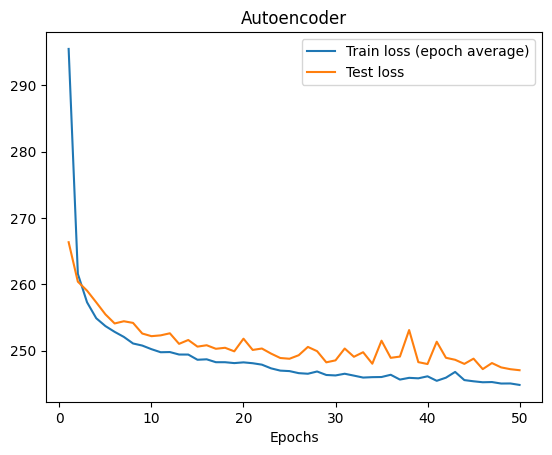

In [6]:
plt.plot(range(1,len(train_loss_history_AE)+1), train_loss_history_AE, label="Train loss (epoch average)")
plt.plot(range(1,len(train_loss_history_AE)+1), test_loss_history_AE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Autoencoder")
plt.show()

## Train the Variational Autoencoder

In [7]:
print("Training Variational Autoencoder...")
model_VAE = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
print(model_VAE)
optimizer = torch.optim.AdamW(model_VAE.parameters(), lr=learning_rate)

train_loss_history_VAE = []
test_loss_history_VAE = []
prev_updates = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_VAE, train_loader, optimizer, prev_updates)
    test_loss = test(model_VAE, test_loader)
    train_loss_history_VAE.append(np.mean(train_loss))
    test_loss_history_VAE.append(test_loss)

Training Variational Autoencoder...
Encoder: [Linear(in_features=784, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=4, bias=True)]
Decoder: [Linear(in_features=2, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Line

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 308.5634


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 278.2646
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 271.7273


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 269.6553
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 266.4945


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 266.0677
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 264.4459


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 265.1745
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 262.8214


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 265.0063
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 262.2881


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.4523
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 260.9971


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 262.0321
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 260.2425


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.3198
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 259.6957


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 263.2609
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 259.7780


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.0804
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 258.5830


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.0243
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 259.1152


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.1006
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 258.2321


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.3215
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 258.1638


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.3544
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 258.0311


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.8557
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 258.1304


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.2808
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 257.8211


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.0413
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 257.3493


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.0024
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 256.8666


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.4269
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 256.1494


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.4623
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 256.2959


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.7620
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 256.5831


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.1082
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 256.6158


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.7632
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 256.5120


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 261.8678
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 258.8731


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.6528
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 256.6172


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6063
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 256.4114


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.1186
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 255.8379


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.5636
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 256.1791


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.3703
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 256.8929


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 263.1747
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 256.9475


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.1951
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 255.4428


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.0734
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 256.3537


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.2764
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 255.2191


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.7266
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 256.0423


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 259.0568
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 255.3301


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.3759
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 255.3345


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.9296
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 255.6996


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0722
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 255.2116


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.9072
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 255.6721


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 260.0636
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 254.7595


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6176
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 255.1135


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6498
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 255.1351


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.2286
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 255.3055


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6878
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 255.6779


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.9802
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 255.0165


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.0266
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 254.5444


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.6110
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 254.5867


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 258.5190
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 254.6468


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 256.9348
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 255.0354


Testing:   0%|          | 0/20 [00:00<?, ?it/s]

====> Test set loss: 257.6953


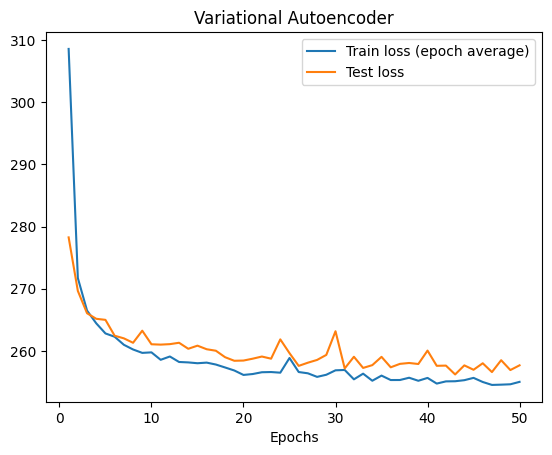

In [8]:
plt.plot(range(1,len(train_loss_history_VAE)+1), train_loss_history_VAE, label="Train loss (epoch average)")
plt.plot(range(1,len(train_loss_history_VAE)+1), test_loss_history_VAE, label="Test loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Variational Autoencoder")
plt.show()

## Plot functions

In [9]:
def plot_latent_space(model, ax, is_conditioned=False):
    model.eval()
    z_all = []
    y_all = []
    
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc='Encoding'):
            y = None
            if is_conditioned:
                y = torch.nn.functional.one_hot(target)
            
            if isinstance(model, AE):
                # AutoEncoder
                z_all.append(model.encode(data, y=y).numpy())
            else: 
                # Variational AutoEncoder
                z_all.append(model.reparameterize(model.encode(data, y=y)).numpy())
                # z_all.append(model.encode(data, y).rsample().numpy()) 
            
            y_all.append(target.numpy())

    z_all = np.concatenate(z_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)

    # plt.figure(figsize=(10, 10))
    scatter = ax.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,6)
    plt.colorbar(scatter, ax=ax) # Error
    ax.set_title(f'Latent projection')
    # subplot.show()

def plot_random_samples(models, is_conditioned=False):
    y_hot = torch.nn.functional.one_hot(torch.LongTensor(list(range(0, 10))))
    
    for name, model in models:
        print(name)
        
        fig, ax = plt.subplots(10, 10, figsize=(10, 10))
        for i in range(10):
            y = None
            
            if is_conditioned:
                y = y_hot[i].repeat(10, 1)
            
            # Normal distribution randomly
            z_samples = torch.randn(10, latent_dim)
            samples = model.decode(z_samples, y)
            
            for j in range(10):
                ax[i, j].imshow(samples[j].view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[i, j].axis('off')
                
        plt.show()

## Show plots

Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

Variational Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

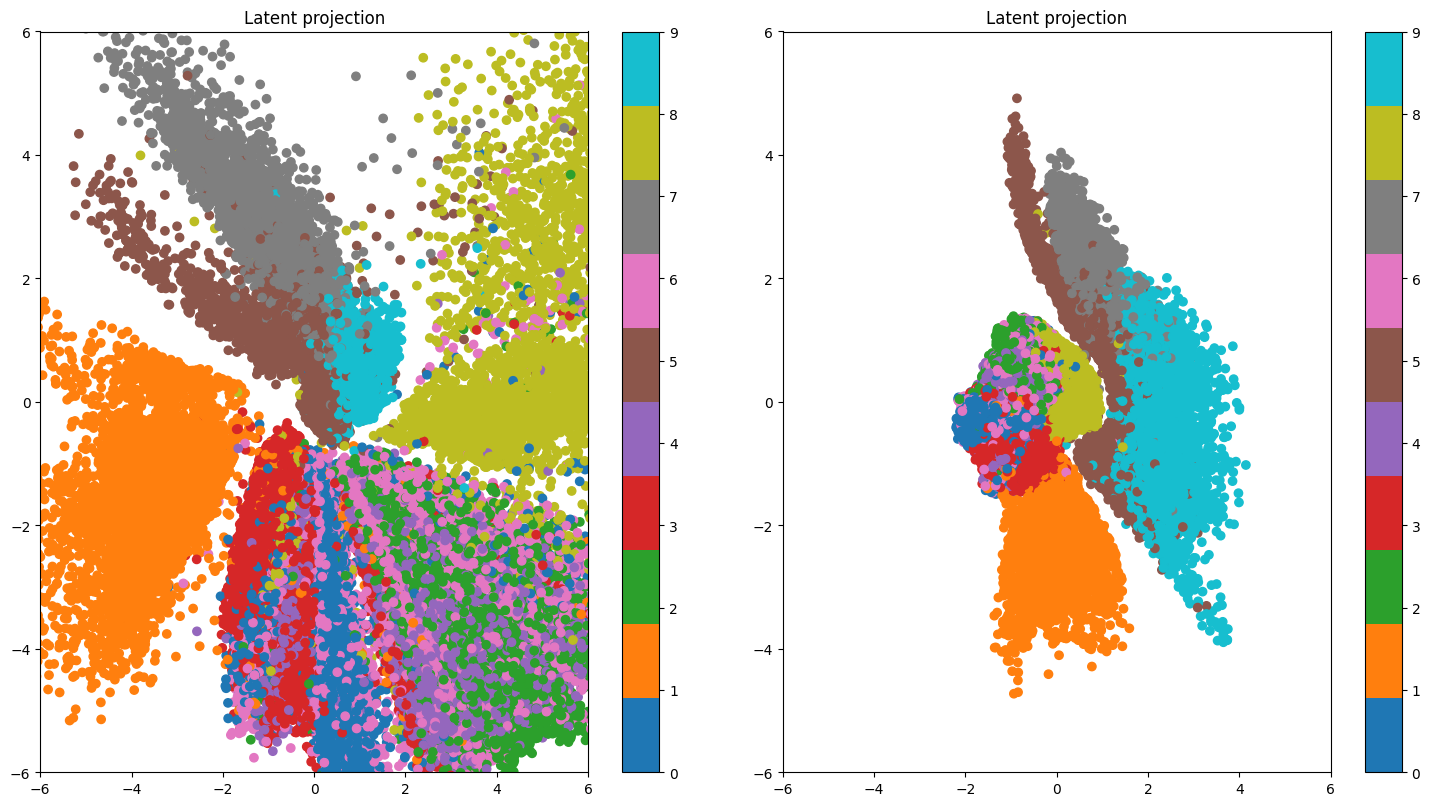

In [11]:
# Subplots
fig, (ax_ae, ax_vae) = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout()

print("Autoencoder:")
plot_latent_space(model_AE, ax_ae)

print("Variational Autoencoder:")
plot_latent_space(model_VAE, ax_vae)

> Ao que parece, o VAE gera um espaço latente mais comportado, possivelmente porque existe uma semântica na distribuição dos pontos de dados. Lado a lado, fico na impressão que as cores que têm _overlap_ se mantêm, assim como as cores que estão mais separadas

> Outra resposta: A diferença é que o AE gera uma flor no espaço latente e o VAE gera uma borboleta com cabeça de humano 😂😂😂😂

Autoencoder


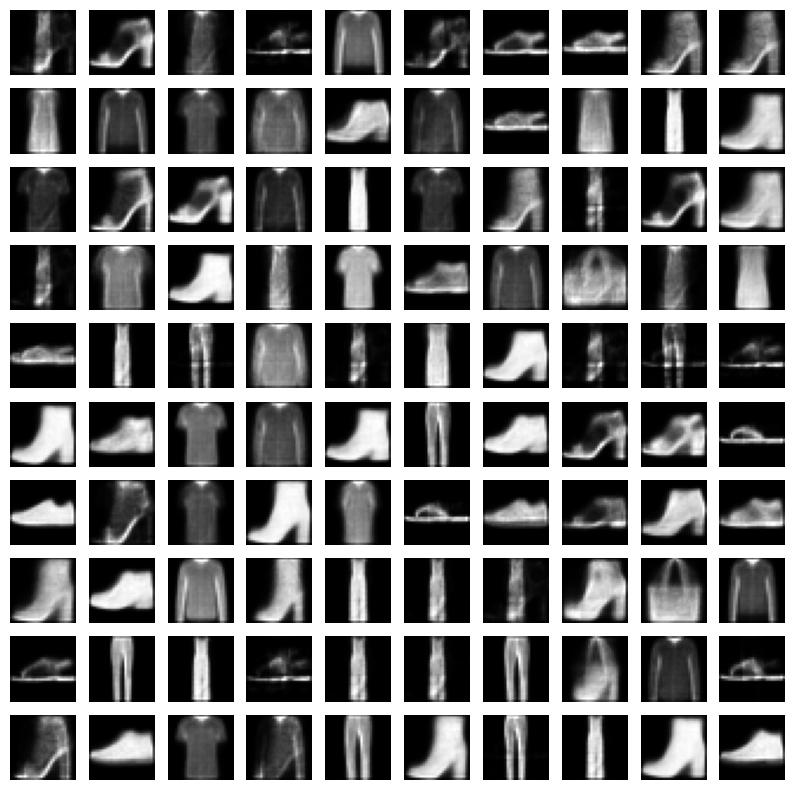

Variational Autoencoder


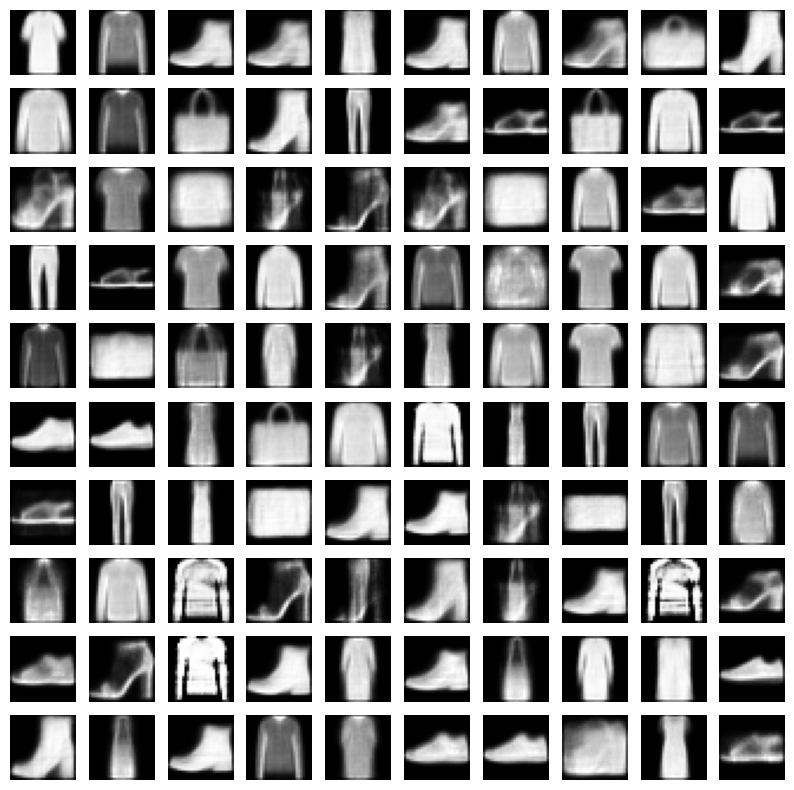

In [12]:
plot_random_samples([("Autoencoder", model_AE), ("Variational Autoencoder", model_VAE)])

> As imagens do AE, ao meu ver, parecem mais nítidas. Testei algumas vezes e fiquei também com a impressão que o VAE tem certa tendência de desenhar os objetos maiores (isto é, que printam mais pixels) como camisas e bolsas.

> Eu mudei a função na ilusão que os modelos gerariam o mesmo tipo de vestimenta e eu poderia comparar 😅😅😅😅 Depois eu percebi o óbvio.

## Conditioned experiments

#### Training autoencoder

In [13]:
print("Training Autoencoder CONDITIONED...")

model_AE_conditioned = AE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, label_dim=label_dim).to(device)
print(model_AE_conditioned)
optimizer = torch.optim.AdamW(model_AE_conditioned.parameters(), lr=learning_rate)

train_loss_history_AE = []
test_loss_history_AE = []
prev_updates = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_AE_conditioned, train_loader, optimizer, prev_updates, is_conditioned=True)
    # test_loss = test(model_AE_conditioned, test_loader)
    # train_loss_history_AE.append(np.mean(train_loss))
    # test_loss_history_AE.append(test_loss)

Training Autoencoder CONDITIONED...
Encoder: [Linear(in_features=794, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=2, bias=True)]
Decoder: [Linear(in_features=12, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
AE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 295.5739
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 250.1661
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 248.3895
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 247.0794
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 246.6240
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 245.9869
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 245.6744
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 245.2465
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 244.9945
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 244.8733
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 244.4569
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 244.2812
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 244.3332
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 244.2279
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 243.7061
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 243.8741
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 243.2718
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 243.5682
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 243.4839
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 243.2508
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 242.7917
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 243.1290
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 243.1017
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 242.8262
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 242.5385
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 243.1044
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 242.5558
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 242.3978
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 242.2191
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 242.4734
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 241.8380
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 242.3007
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 241.9555
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 242.0891
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 241.5628
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 241.5770
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 241.6021
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 241.2829
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 241.4780
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 241.3098
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 241.4866
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 241.2472
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 241.3901
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 241.0517
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 241.3152
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 241.0219
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 241.0736
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 240.8956
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 240.8566
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 240.9627


#### Training variational autoencoder

In [14]:
print("Training Variational Autoencoder CONDITIONED...")
model_VAE_conditioned = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, label_dim=label_dim).to(device)
print(model_VAE_conditioned)
optimizer = torch.optim.AdamW(model_VAE_conditioned.parameters(), lr=learning_rate)

train_loss_history_VAE = []
test_loss_history_VAE = []
prev_updates = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates, train_loss = train(model_VAE_conditioned, train_loader, optimizer, prev_updates, is_conditioned=True)
    # test_loss = test(model_VAE, test_loader)
    # train_loss_history_VAE.append(np.mean(train_loss))
    # test_loss_history_VAE.append(test_loss)

Training Variational Autoencoder CONDITIONED...
Encoder: [Linear(in_features=794, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=4, bias=True)]
Decoder: [Linear(in_features=12, out_features=256, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=256, out_features=512, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=512, out_features=784, bias=True), Sigmoid()]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)

Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 117 (N samples: 59,904), Train set loss: 287.6145
Epoch 2/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 235 (N samples: 120,320), Train set loss: 257.0434
Epoch 3/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 353 (N samples: 180,736), Train set loss: 254.7578
Epoch 4/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 471 (N samples: 241,152), Train set loss: 254.0644
Epoch 5/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 589 (N samples: 301,568), Train set loss: 253.1504
Epoch 6/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 707 (N samples: 361,984), Train set loss: 252.6075
Epoch 7/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 825 (N samples: 422,400), Train set loss: 251.9524
Epoch 8/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 943 (N samples: 482,816), Train set loss: 251.7887
Epoch 9/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,061 (N samples: 543,232), Train set loss: 251.9111
Epoch 10/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,179 (N samples: 603,648), Train set loss: 251.0295
Epoch 11/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,297 (N samples: 664,064), Train set loss: 250.9723
Epoch 12/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,415 (N samples: 724,480), Train set loss: 250.6091
Epoch 13/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,533 (N samples: 784,896), Train set loss: 250.2594
Epoch 14/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,651 (N samples: 845,312), Train set loss: 250.6635
Epoch 15/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,769 (N samples: 905,728), Train set loss: 250.3964
Epoch 16/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 1,887 (N samples: 966,144), Train set loss: 249.9484
Epoch 17/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,005 (N samples: 1,026,560), Train set loss: 249.5969
Epoch 18/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,123 (N samples: 1,086,976), Train set loss: 249.5361
Epoch 19/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,241 (N samples: 1,147,392), Train set loss: 249.6838
Epoch 20/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,359 (N samples: 1,207,808), Train set loss: 249.7358
Epoch 21/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,477 (N samples: 1,268,224), Train set loss: 249.6630
Epoch 22/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,595 (N samples: 1,328,640), Train set loss: 249.0370
Epoch 23/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,713 (N samples: 1,389,056), Train set loss: 248.8997
Epoch 24/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,831 (N samples: 1,449,472), Train set loss: 248.8337
Epoch 25/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 2,949 (N samples: 1,509,888), Train set loss: 249.4479
Epoch 26/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,067 (N samples: 1,570,304), Train set loss: 248.9840
Epoch 27/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,185 (N samples: 1,630,720), Train set loss: 249.2205
Epoch 28/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,303 (N samples: 1,691,136), Train set loss: 248.5477
Epoch 29/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,421 (N samples: 1,751,552), Train set loss: 248.6452
Epoch 30/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,539 (N samples: 1,811,968), Train set loss: 248.5295
Epoch 31/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,657 (N samples: 1,872,384), Train set loss: 248.2046
Epoch 32/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,775 (N samples: 1,932,800), Train set loss: 248.3249
Epoch 33/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 3,893 (N samples: 1,993,216), Train set loss: 248.3297
Epoch 34/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,011 (N samples: 2,053,632), Train set loss: 248.4471
Epoch 35/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,129 (N samples: 2,114,048), Train set loss: 248.0475
Epoch 36/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,247 (N samples: 2,174,464), Train set loss: 247.9363
Epoch 37/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,365 (N samples: 2,234,880), Train set loss: 247.8949
Epoch 38/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,483 (N samples: 2,295,296), Train set loss: 248.1971
Epoch 39/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,601 (N samples: 2,355,712), Train set loss: 247.7694
Epoch 40/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,719 (N samples: 2,416,128), Train set loss: 247.8908
Epoch 41/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,837 (N samples: 2,476,544), Train set loss: 247.9286
Epoch 42/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 4,955 (N samples: 2,536,960), Train set loss: 247.7873
Epoch 43/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,073 (N samples: 2,597,376), Train set loss: 247.6981
Epoch 44/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,191 (N samples: 2,657,792), Train set loss: 247.9067
Epoch 45/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,309 (N samples: 2,718,208), Train set loss: 247.7026
Epoch 46/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,427 (N samples: 2,778,624), Train set loss: 247.3796
Epoch 47/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,545 (N samples: 2,839,040), Train set loss: 247.3726
Epoch 48/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,663 (N samples: 2,899,456), Train set loss: 247.2478
Epoch 49/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,781 (N samples: 2,959,872), Train set loss: 247.4001
Epoch 50/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]

Step 5,899 (N samples: 3,020,288), Train set loss: 247.5694


Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

Variational Autoencoder:


Encoding:   0%|          | 0/118 [00:00<?, ?it/s]

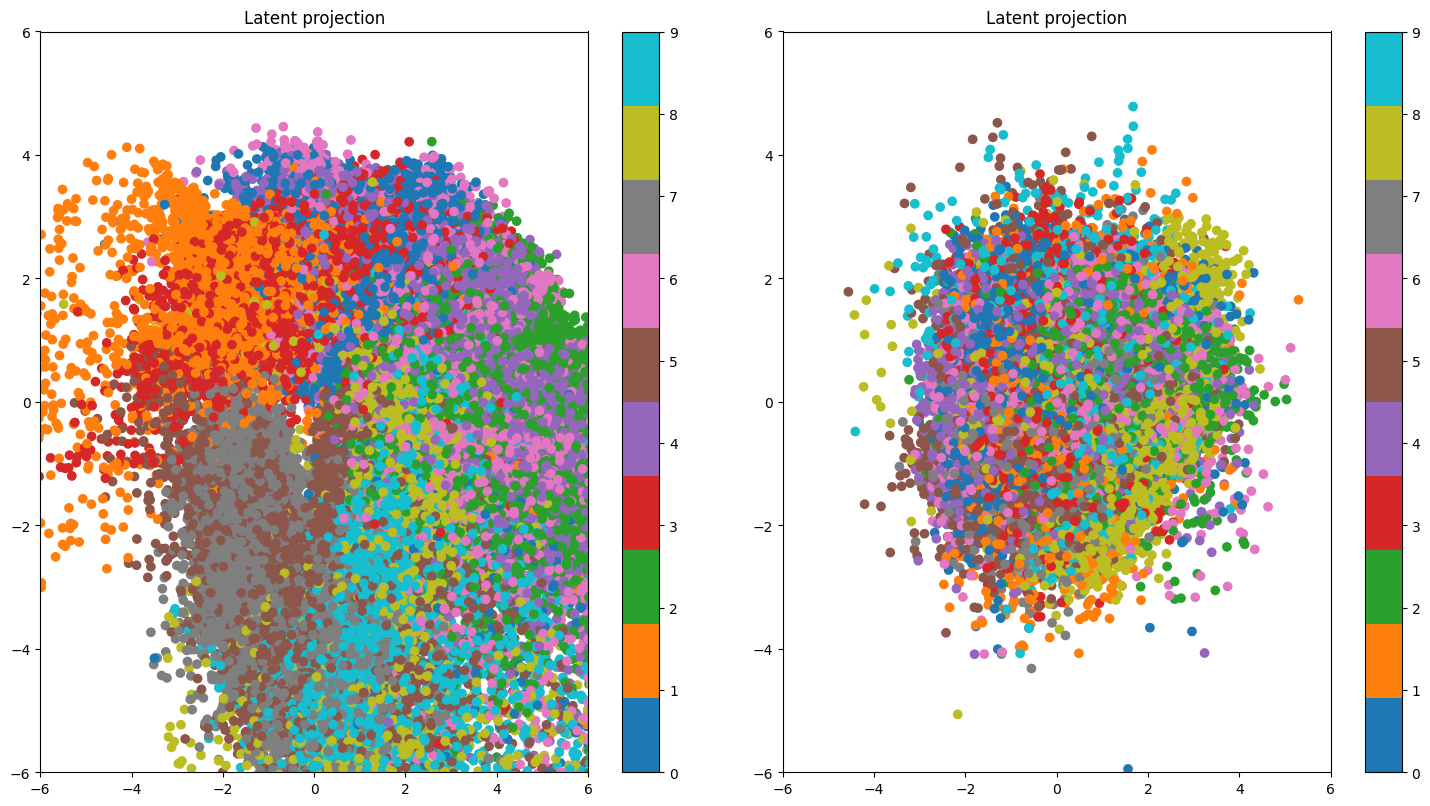

In [15]:
# Subplots
fig, (ax_ae, ax_vae) = plt.subplots(1, 2, figsize=(15, 8))
fig.tight_layout()

print("Autoencoder:")
plot_latent_space(model_AE_conditioned, ax_ae, is_conditioned=True)

print("Variational Autoencoder:")
plot_latent_space(model_VAE_conditioned, ax_vae, is_conditioned=True)

> Agora os espaços latentes parecem mais similares, mas o VAE apresenta um espaço mais controlado e arriscaria dizer que os pontos aparentam formar uma gaussiana (vista de cima)

Autoencoder CONDITIONED


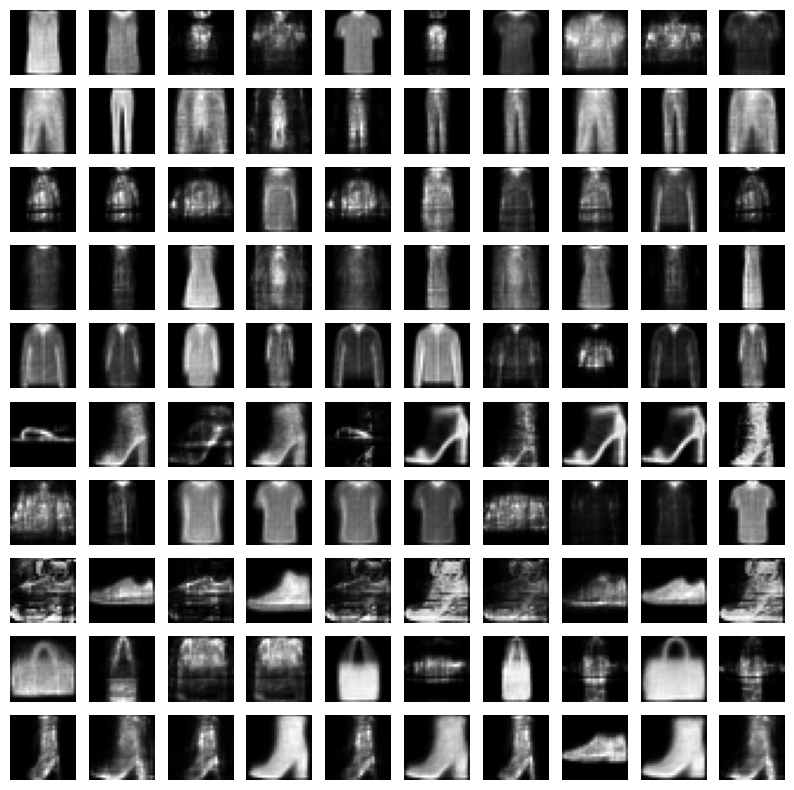

Variational Autoencoder CONDITIONED


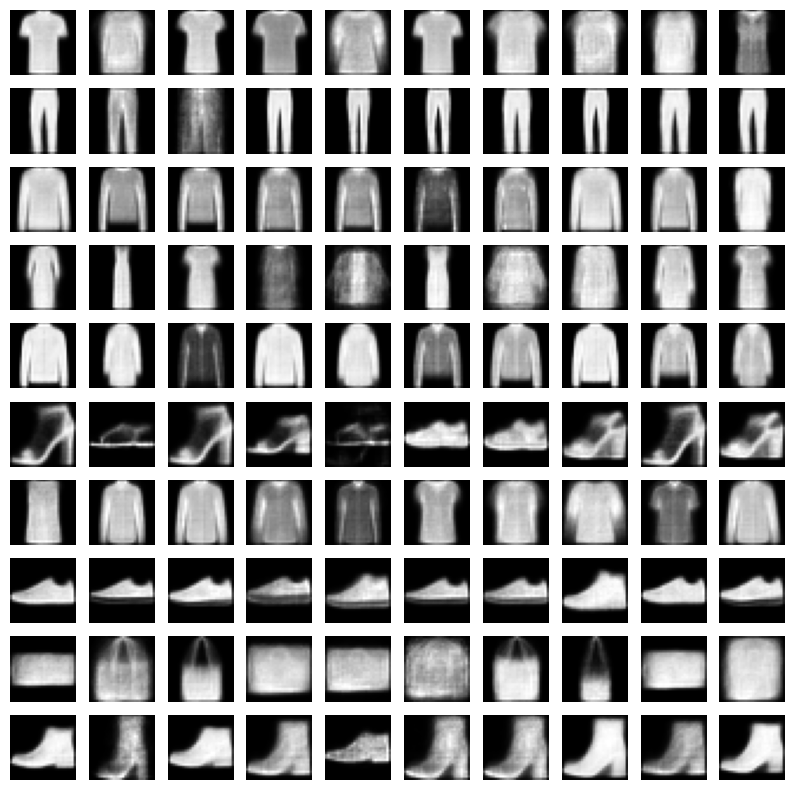

In [16]:
plot_random_samples(
    [("Autoencoder CONDITIONED", model_AE_conditioned), ("Variational Autoencoder CONDITIONED", model_VAE_conditioned)], 
    is_conditioned=True)